# Import library

In [3]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

# import os
# print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [6]:
#importing the training data
df=pd.read_csv('IMDB Dataset.csv')
print(df.shape)
df.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# EDA

In [8]:
#Summary of the dataset
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [9]:
#sentiment count
from collections import Counter
Counter(df['sentiment'])

Counter({'positive': 25000, 'negative': 25000})

In [10]:
#split the dataset  
threshold = int(len(df) * 0.8)

#train dataset
train_X=df.review[:threshold]
train_y=df.sentiment[:threshold]
#test dataset
test_X=df.review[threshold:]
test_y=df.sentiment[threshold:]
print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

(40000,) (40000,)
(10000,) (10000,)


# Text normalization

In [11]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

# Removing html strips and noise text

In [19]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on review column
df['review']=df['review'].apply(denoise_text)

# Removing special characters

In [20]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

# Text stemming

In [21]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function on review column
df['review']=df['review'].apply(simple_stemmer)

# Removing stopwords

In [22]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on review column
df['review']=df['review'].apply(remove_stopwords)

{'them', "you'll", 'can', 'ours', 'those', 'was', 'she', 've', 'this', 'mustn', 'under', "hasn't", 'its', 'ma', 'won', 'my', 'both', 'been', 'same', 'has', 'most', 'm', 'being', 'having', "won't", 'am', 'were', 'during', 'below', "haven't", 'yourself', 'when', 'over', 'while', 'on', "weren't", 'for', 'too', 'here', "she's", 'about', 'yours', 'down', 'ain', 'few', 'o', 'myself', "that'll", 'out', 'no', "doesn't", 'before', 'weren', "needn't", 's', 'their', 'shan', 'will', 'because', 'from', 'couldn', 'aren', 'more', 'doesn', 'mightn', 'who', 'now', "shan't", 'it', 'whom', 'itself', "it's", 'very', 'which', 'an', 'didn', 'herself', 'with', 'wasn', 'why', 'a', 'at', 'between', 'don', "you're", 'are', 'by', 'does', 'where', 'did', 'all', 'd', 'or', 'had', 'once', 'isn', 'each', 'should', 'your', 'above', 'her', 'further', 'they', 'needn', "hadn't", 'through', 'and', 'against', "aren't", 'only', 'but', "should've", 'as', 'him', 'himself', 're', 'is', 'in', 'me', 'yourselves', 'if', 'up', 'h

# Make normalized train / test data

(option 1) Bag of words

In [27]:
norm_train_X = train_X.copy()
norm_test_X = test_X.copy()
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_X=cv.fit_transform(norm_train_X)
#transformed test reviews
cv_test_X=cv.transform(norm_test_X)

print('BOW_cv_train:',cv_train_X.shape)
print('BOW_cv_test:',cv_test_X.shape)

BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


(Option 2) Term Frequency-Inverse Document Frequency model (TFIDF)

In [28]:
norm_train_X = train_X.copy()
norm_test_X = test_X.copy()
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_X=tv.fit_transform(norm_train_X)
#transformed test reviews
tv_test_X=tv.transform(norm_test_X)
print('Tfidf_train:',tv_train_X.shape)
print('Tfidf_test:',tv_test_X.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


Labelize the sentiment text

In [29]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(df['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [31]:
#test dataset
train_sentiments=sentiment_data[:threshold]
test_sentiments=sentiment_data[threshold:]

In [35]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_X,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_X,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [36]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_X)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_X)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


In [37]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



<function matplotlib.pyplot.show(*args, **kw)>

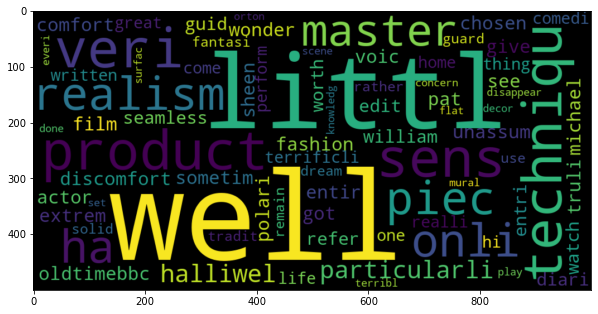

In [39]:
plt.figure(figsize=(10,10))
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words = WC.generate(norm_train_X[1])
plt.imshow(positive_words,interpolation='bilinear')
plt.show